In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib.cm import get_cmap

# Allgather 

In [55]:
df_multinode = pd.read_csv("data/data-multi-defand100cflag.csv",delimiter = ",")
df_multinode['benchmark_type'].unique()
df_allgather = df_multinode[df_multinode["benchmark_type"]=="Allgather"][df_multinode['off_cache_flag']==-1][df_multinode['msg_size_bytes']>1024][df_multinode['proc_num']>0]

/tmp/ipykernel_10800/1470334786.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_allgather = df_multinode[df_multinode["benchmark_type"]=="Allgather"][df_multinode['off_cache_flag']==-1][df_multinode['msg_size_bytes']>1024][df_multinode['proc_num']>0]
/tmp/ipykernel_10800/1470334786.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_allgather = df_multinode[df_multinode["benchmark_type"]=="Allgather"][df_multinode['off_cache_flag']==-1][df_multinode['msg_size_bytes']>1024][df_multinode['proc_num']>0]
/tmp/ipykernel_10800/1470334786.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_allgather = df_multinode[df_multinode["benchmark_type"]=="Allgather"][df_multinode['off_cache_flag']==-1][df_multinode['msg_size_bytes']>1024][df_multinode['proc_num']>0]


/tmp/ipykernel_10800/119527997.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


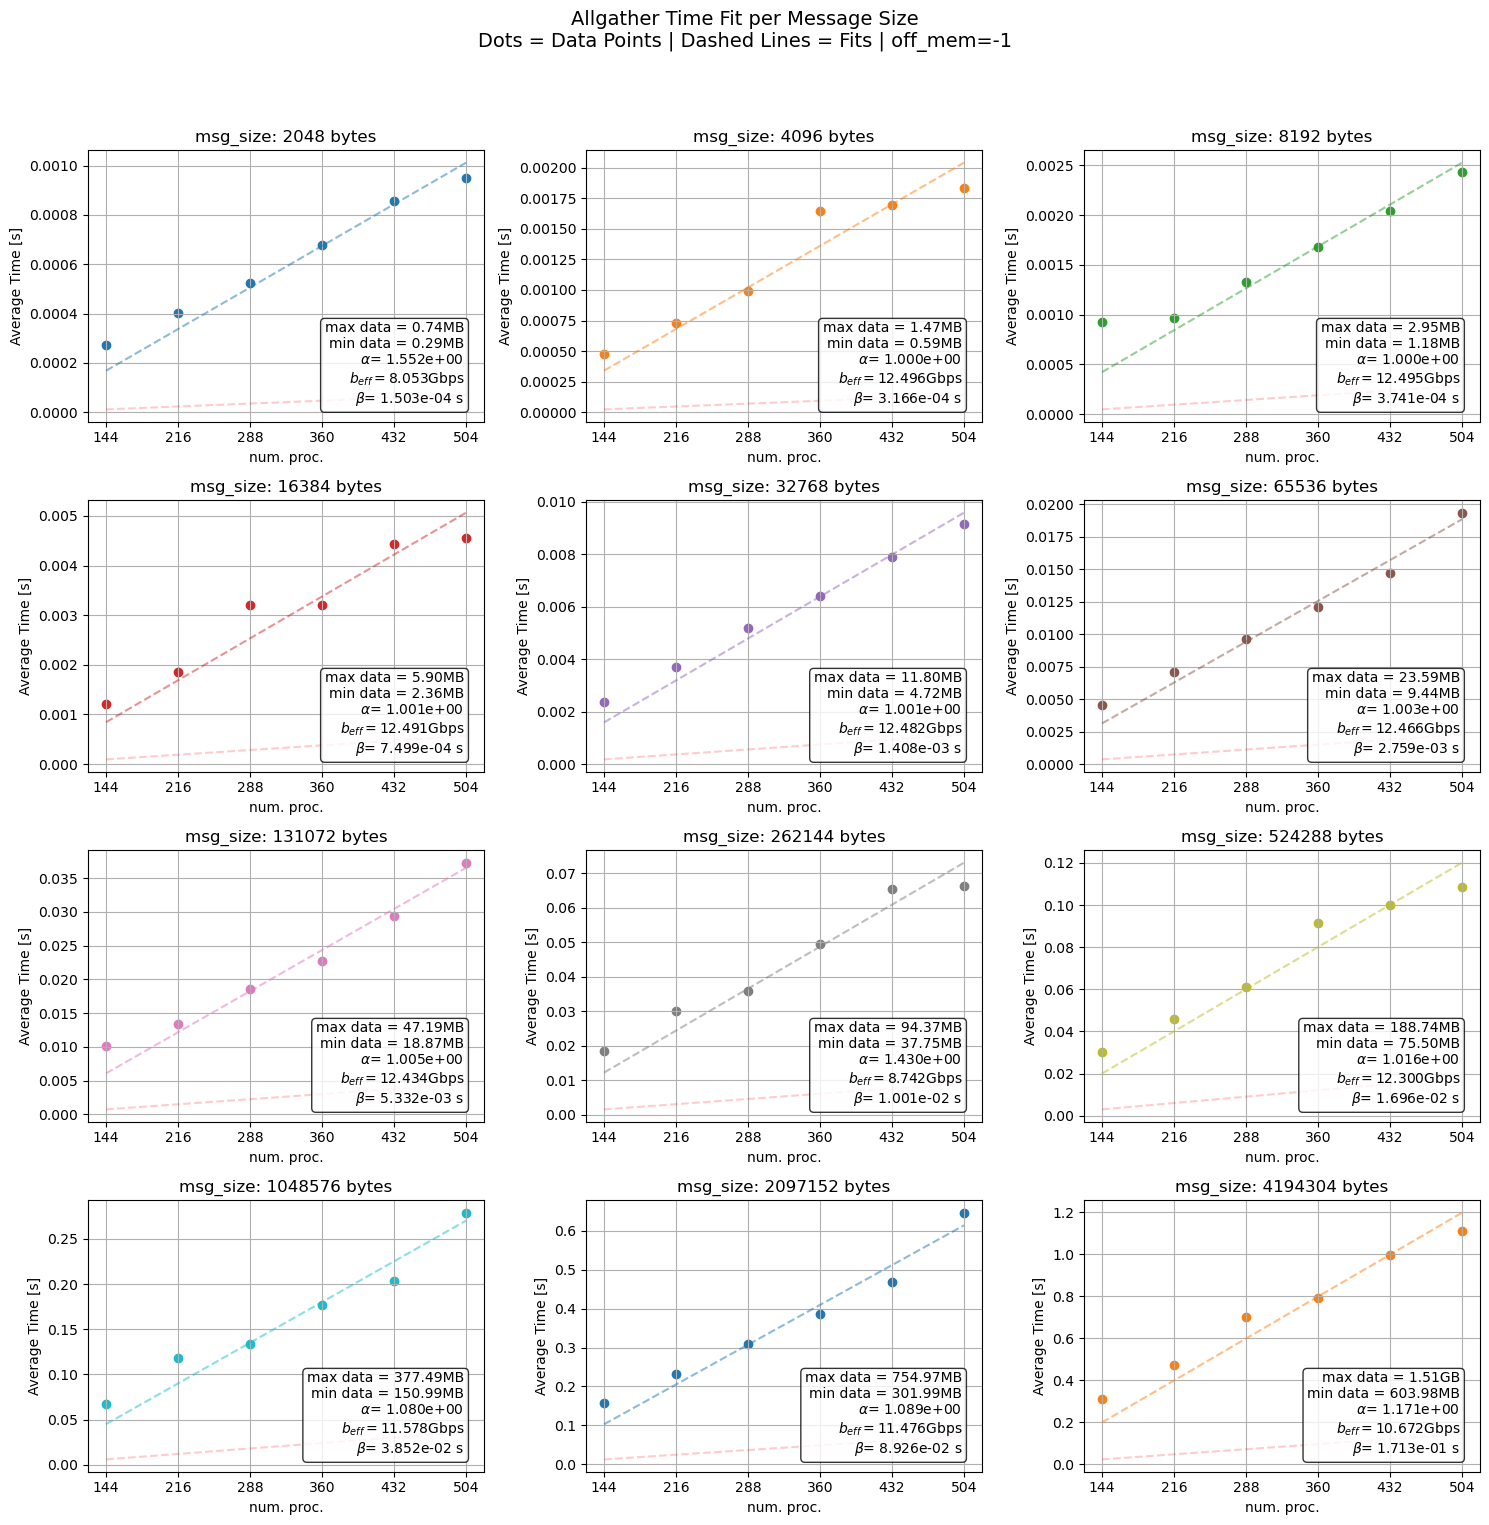

    msg_size_bytes     alpha      beta  inv_alpha
0             2048  1.552236  0.000150   0.644232
1             4096  1.000317  0.000317   0.999684
2             8192  1.000374  0.000374   0.999626
3            16384  1.000750  0.000750   0.999250
4            32768  1.001409  0.001408   0.998593
5            65536  1.002759  0.002759   0.997249
6           131072  1.005332  0.005332   0.994696
7           262144  1.429840  0.010007   0.699379
8           524288  1.016241  0.016955   0.984018
9          1048576  1.079597  0.038522   0.926272
10         2097152  1.089258  0.089258   0.918056
11         4194304  1.171323  0.171323   0.853735


In [60]:

def model(proc_num, alpha, beta, msg_size):
   return (proc_num/72-1)*((alpha*(msg_size)*72)/(12500)+1e6*beta) 

results = []
msg_sizes = sorted(df_allgather['msg_size_bytes'].unique())
n_rows = int(np.ceil(len(msg_sizes) / 3))
n_cols = min(len(msg_sizes), 3)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)
cmap = get_cmap('tab10')

for idx, (msg_size, group) in enumerate(df_allgather.groupby('msg_size_bytes')):
    x = group['proc_num'].values
    y = group['t_avg_usec'].values

    fit_func = lambda proc_num, alpha, beta: model(proc_num, alpha, beta, msg_size)
    popt, _ = curve_fit(fit_func, x, y, bounds=([1, 0], [np.inf, np.inf]))
    alpha, beta = popt
    results.append({'msg_size_bytes': msg_size, 'alpha': alpha, 'beta': beta})

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = fit_func(x_fit, alpha, beta)
    y_speed = model(x_fit,1,0,msg_size)
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    color = cmap(idx % 10)
    ax.scatter(x, y/1e6, label='Data', color=color)
    ax.plot(x_fit, y_fit/1e6, linestyle='--', color=color, alpha=0.5, label='Fit')
    ax.plot(x_fit, y_speed/1e6, linestyle='--', color='red', alpha=0.2, label='Fit')
    ax.set_title(f'msg_size: {msg_size} bytes')
    ax.set_xlabel('num. proc.')
    ax.set_ylabel('Average Time [s]')
    ax.set_xticks(x)
    ax.grid(True)
    max_data =(x[-1]-72)*msg_size
    min_data =(x[0]-72)*msg_size

    textstr = ""
    if(max_data > 1e9):
        textstr+=f"max data = {max_data/1e9:0.2f}GB\n" 
    else:
        textstr+=f"max data = {max_data/1e6:0.2f}MB\n" 

    if(min_data > 1e9):
        textstr+=f"min data = {min_data/1e9:0.2f}GB\n" 
    else:
        textstr+=f"min data = {min_data/1e6:0.2f}MB\n" 
    textstr += r"$\alpha$" +f"= {alpha:.3e}\n"+r"$b_{eff}=$"+f"{12.5/alpha:0.3f}Gbps\n"+\
               r"$\beta$"+f"= {beta:.3e} s"
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes,
            fontsize=10, verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle('Allgather Time Fit per Message Size\nDots = Data Points | Dashed Lines = Fits | off_mem=-1', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("plots/allgather_analysis.png",dpi=300)
plt.show()

fit_results = pd.DataFrame(results)
fit_results['inv_alpha'] = 1 / fit_results['alpha']
print(fit_results)

In [64]:
df_multinode_2 = pd.read_csv("data/data-multi-MPIF-100cflag-complete.csv",delimiter = ",")
df_allgather_2 = df_multinode_2[df_multinode_2["benchmark_type"]=="Allgather"][df_multinode_2['off_cache_flag']==100][df_multinode_2['msg_size_bytes']>1024][df_multinode_2['proc_num']>0]

/tmp/ipykernel_10800/695385123.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_allgather_2 = df_multinode_2[df_multinode_2["benchmark_type"]=="Allgather"][df_multinode_2['off_cache_flag']==100][df_multinode_2['msg_size_bytes']>1024][df_multinode_2['proc_num']>0]
/tmp/ipykernel_10800/695385123.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_allgather_2 = df_multinode_2[df_multinode_2["benchmark_type"]=="Allgather"][df_multinode_2['off_cache_flag']==100][df_multinode_2['msg_size_bytes']>1024][df_multinode_2['proc_num']>0]
/tmp/ipykernel_10800/695385123.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_allgather_2 = df_multinode_2[df_multinode_2["benchmark_type"]=="Allgather"][df_multinode_2['off_cache_flag']==100][df_multinode_2['msg_size_bytes']>1024][df_multinode_2['proc_num']>0]


/tmp/ipykernel_10800/1198317908.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


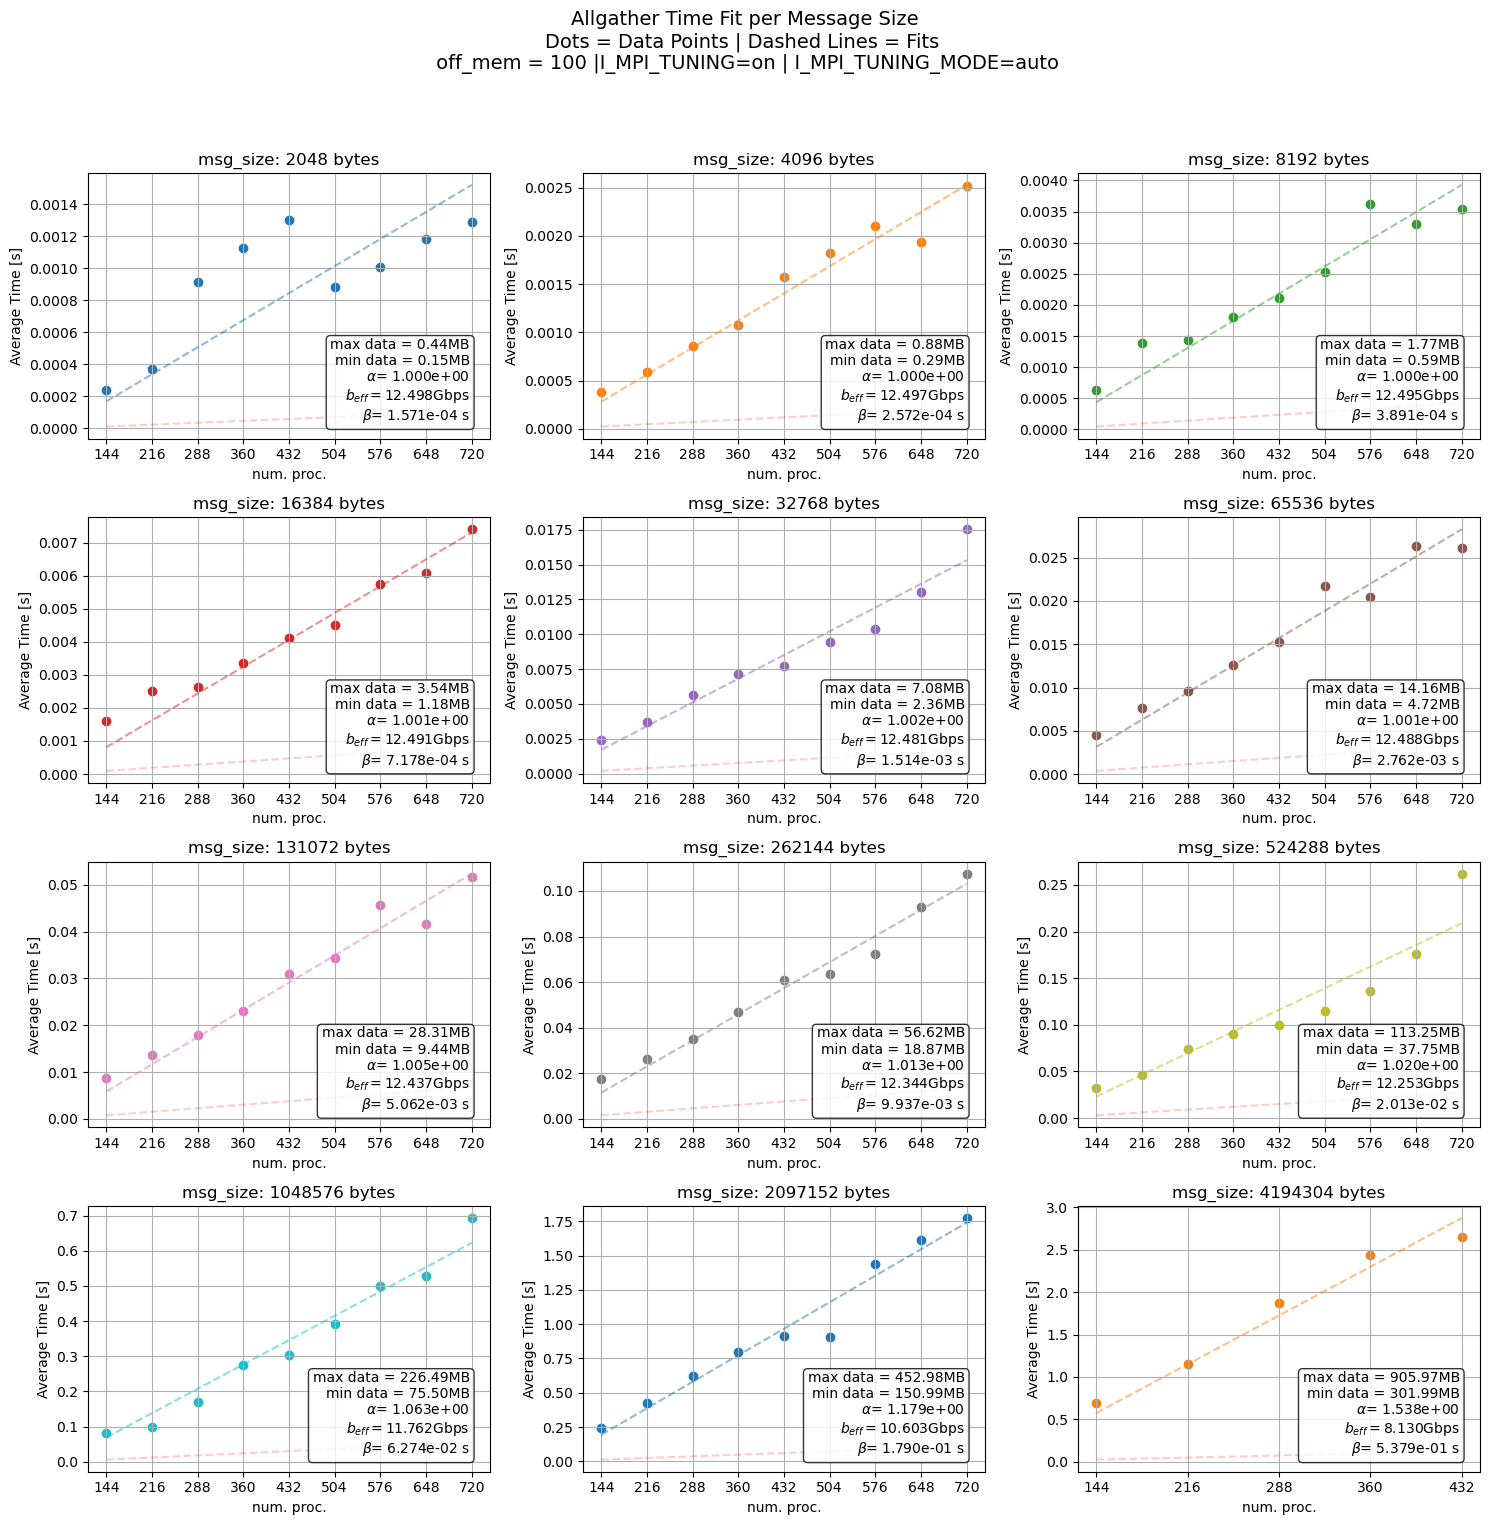

    msg_size_bytes     alpha      beta  inv_alpha
0             2048  1.000157  0.000157   0.999843
1             4096  1.000257  0.000257   0.999743
2             8192  1.000389  0.000389   0.999611
3            16384  1.000718  0.000718   0.999283
4            32768  1.001514  0.001514   0.998488
5            65536  1.000996  0.002762   0.999005
6           131072  1.005062  0.005062   0.994964
7           262144  1.012598  0.009937   0.987559
8           524288  1.020122  0.020125   0.980275
9          1048576  1.062741  0.062742   0.940963
10         2097152  1.178951  0.179023   0.848211
11         4194304  1.537594  0.537920   0.650367


In [65]:

def model_2(proc_num, alpha, beta, msg_size):
   return (proc_num/72-1)*((alpha*(msg_size)*72)/(12500)+1e6*beta) 

results = []
msg_sizes = sorted(df_allgather_2['msg_size_bytes'].unique())
n_rows = int(np.ceil(len(msg_sizes) / 3))
n_cols = min(len(msg_sizes), 3)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)
cmap = get_cmap('tab10')

for idx, (msg_size, group) in enumerate(df_allgather_2.groupby('msg_size_bytes')):
    x = group['proc_num'].values
    y = group['t_avg_usec'].values

    fit_func = lambda proc_num, alpha, beta: model_2(proc_num, alpha, beta, msg_size)
    popt, _ = curve_fit(fit_func, x, y, bounds=([1, 0], [np.inf, np.inf]))
    alpha, beta = popt
    results.append({'msg_size_bytes': msg_size, 'alpha': alpha, 'beta': beta})

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = fit_func(x_fit, alpha, beta)
    y_speed = model_2(x_fit,1,0,msg_size)
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    color = cmap(idx % 10)
    ax.scatter(x, y/1e6, label='Data', color=color)
    ax.plot(x_fit, y_fit/1e6, linestyle='--', color=color, alpha=0.5, label='Fit')
    ax.plot(x_fit, y_speed/1e6, linestyle='--', color='red', alpha=0.2, label='Fit')
    ax.set_title(f'msg_size: {msg_size} bytes')
    ax.set_xlabel('num. proc.')
    ax.set_ylabel('Average Time [s]')
    ax.set_xticks(x)
    ax.grid(True)
    max_data =(x[-1]-72)*msg_size
    min_data =(x[0]-72)*msg_size

    textstr = ""
    if(max_data > 1e9):
        textstr+=f"max data = {max_data/1e9:0.2f}GB\n" 
    else:
        textstr+=f"max data = {max_data/1e6:0.2f}MB\n" 

    if(min_data > 1e9):
        textstr+=f"min data = {min_data/1e9:0.2f}GB\n" 
    else:
        textstr+=f"min data = {min_data/1e6:0.2f}MB\n" 
    textstr += r"$\alpha$" +f"= {alpha:.3e}\n"+r"$b_{eff}=$"+f"{12.5/alpha:0.3f}Gbps\n"+\
               r"$\beta$"+f"= {beta:.3e} s"
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes,
            fontsize=10, verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


fig.suptitle('Allgather Time Fit per Message Size\nDots = Data Points | Dashed Lines = Fits \n off_mem = 100 |I_MPI_TUNING=on | I_MPI_TUNING_MODE=auto', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("plots/allgather2_analysis.png",dpi=300)
plt.show()

fit_results = pd.DataFrame(results)
fit_results['inv_alpha'] = 1 / fit_results['alpha']
print(fit_results)
